Fetching and merging data...
File data/GSM6611295_P15306_5001_matrix.mtx already exists, skipping download...
File data/GSM6611295_P15306_5001_barcodes.tsv already exists, skipping download...
File data/GSM6611295_P15306_5001_features.tsv already exists, skipping download...
File data/GSM6611296_P15306_5002_matrix.mtx already exists, skipping download...
File data/GSM6611296_P15306_5002_barcodes.tsv already exists, skipping download...
File data/GSM6611296_P15306_5002_features.tsv already exists, skipping download...
File data/GSM6611297_P14601_4004_matrix.mtx already exists, skipping download...
File data/GSM6611297_P14601_4004_barcodes.tsv already exists, skipping download...
File data/GSM6611297_P14601_4004_features.tsv already exists, skipping download...
File data/GSM6611298_P14601_4005_matrix.mtx already exists, skipping download...
File data/GSM6611298_P14601_4005_barcodes.tsv already exists, skipping download...
File data/GSM6611298_P14601_4005_features.tsv already exists, skip

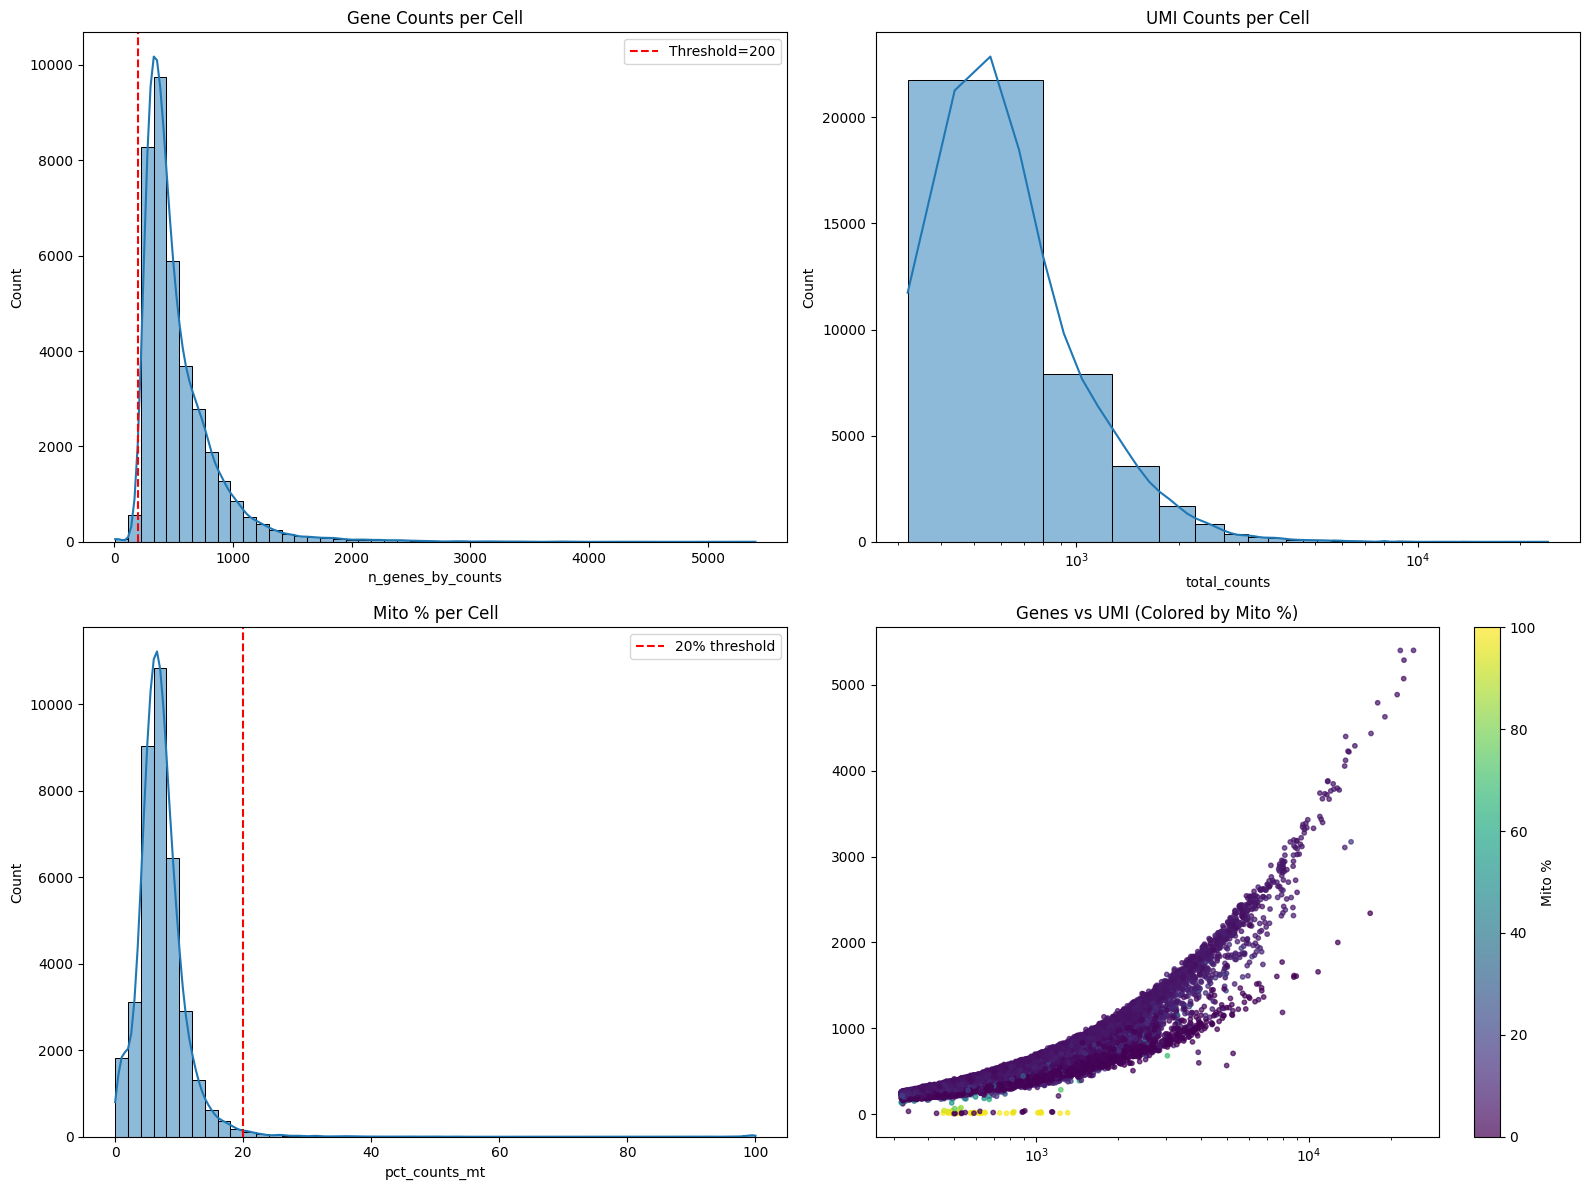

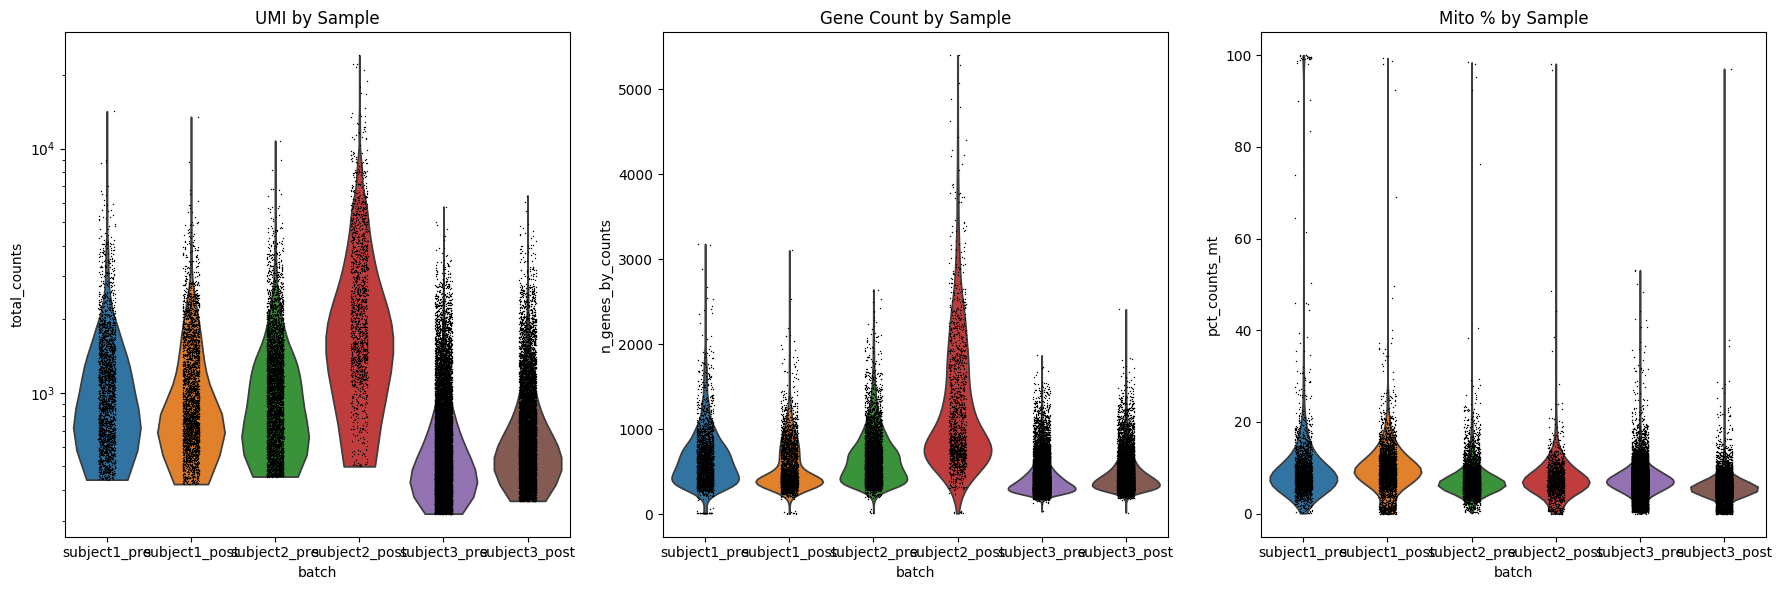

Initial dataset: 37008 cells, 33538 genes.
After QC filter: 10809 cells, 14400 genes.


/home/jovyan/.local/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


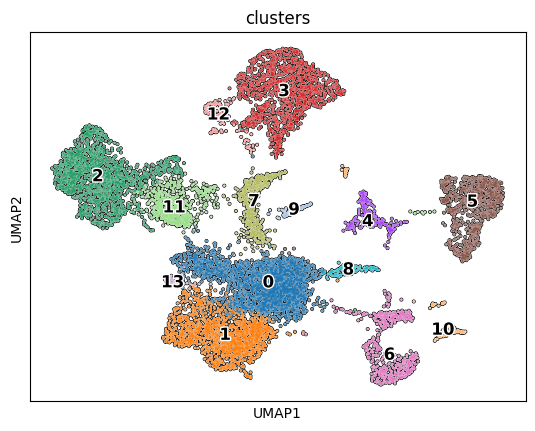

Silhouette Score: 0.15531152486801147
Top 3 markers per cluster:
           group     names     scores  logfoldchanges          pvals  \
0  0          0  SLC9A3R2  52.202908       23.359257   0.000000e+00   
   1          0     FABP4  51.705406       36.160259   0.000000e+00   
   2          0     FABP5  51.684338       29.889349   0.000000e+00   
1  14400      1     IFI27  52.559021       57.520481   0.000000e+00   
   14401      1     ISG15  49.790550       21.933491   0.000000e+00   
   14402      1       A2M  49.398048       31.121574   0.000000e+00   
2  28800      2       DCN  65.856918      219.254745   0.000000e+00   
   28801      2       GSN  64.210724      138.025986   0.000000e+00   
   28802      2       CFD  60.884686      264.955658   0.000000e+00   
3  43200      3      MYL2  58.421299      712.951843   0.000000e+00   
   43201      3     TNNC1  58.342094      361.066223   0.000000e+00   
   43202      3        MB  58.325264      273.780457   0.000000e+00   
4  57600   

/home/jovyan/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


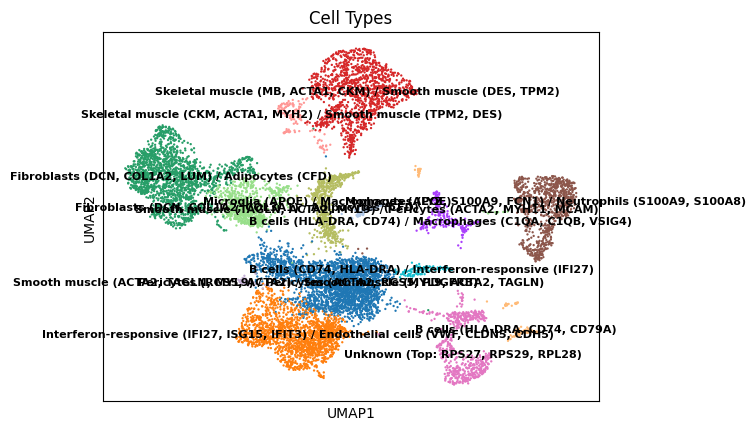

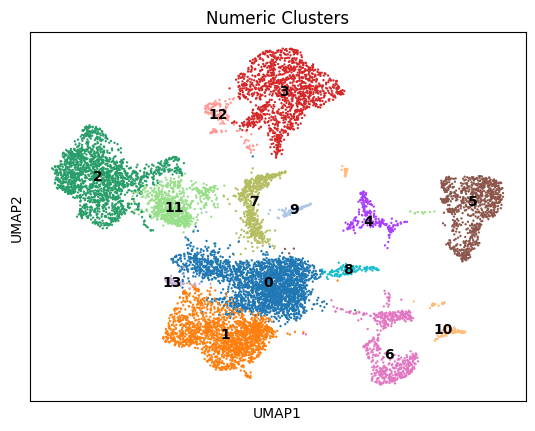


Cluster composition (%):
 clusters
0     23.156629
2     16.773059
1     15.366824
3     12.175039
5      8.011842
11     7.031178
6      5.384402
7      5.171616
4      2.053844
12     1.295217
8      1.156444
10     1.082431
9      0.823388
13     0.518087
Name: count, dtype: float64


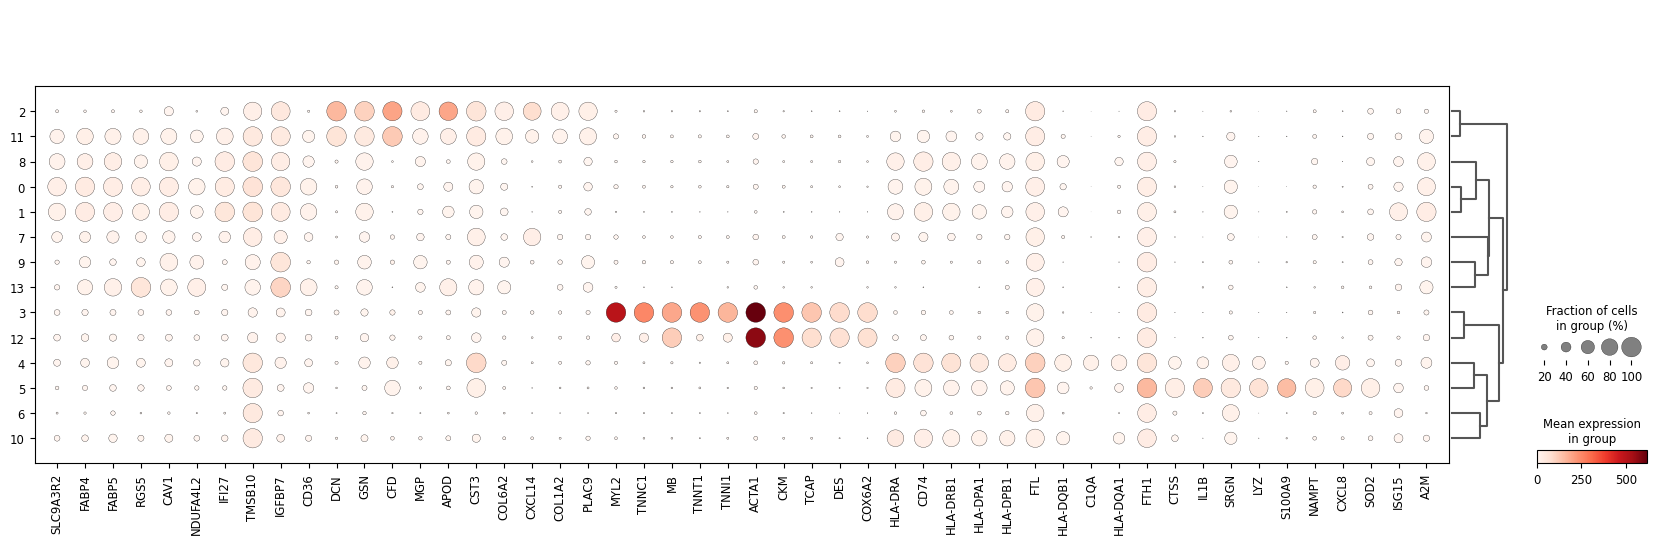

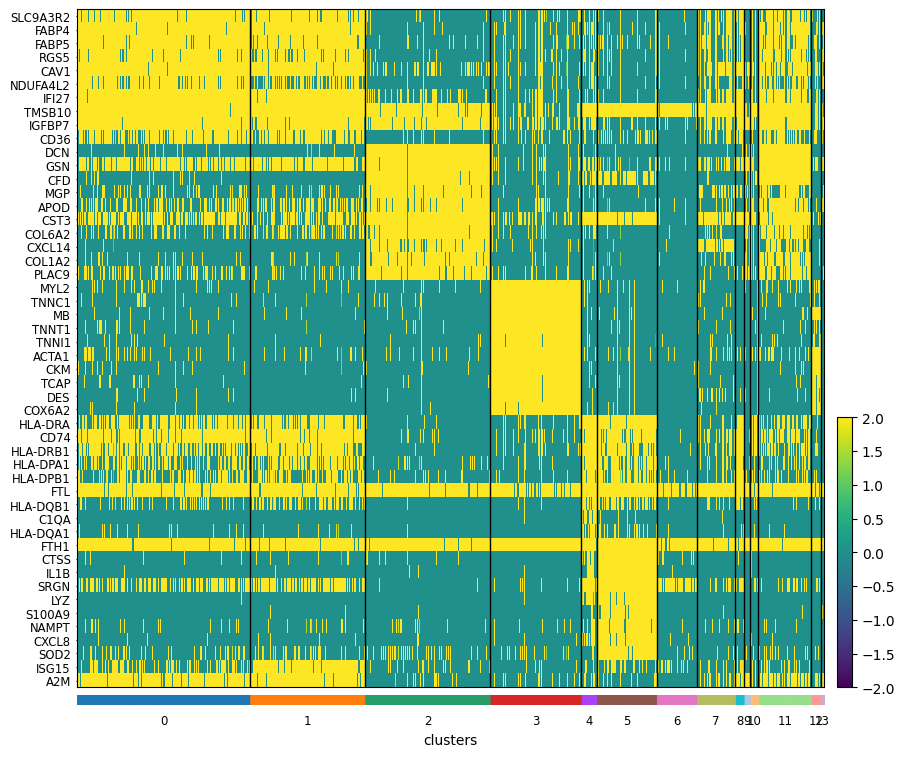


Intra-cluster DE between 'condition' states:
Starting condition-based comparison within each cluster: condition.
Comparing 'post' against 'pre' for each cluster.

Evaluating cluster 0...
  Condition counts: 1446 in pre, 1057 in post.
  Identified 174 genes with adj p < 0.05.
    111 up in post, 63 down in post.

Evaluating cluster 2...
  Condition counts: 1298 in pre, 515 in post.
  Identified 99 genes with adj p < 0.05.
    89 up in post, 10 down in post.

Evaluating cluster 3...
  Condition counts: 792 in pre, 524 in post.
  Identified 49 genes with adj p < 0.05.
    30 up in post, 19 down in post.

Evaluating cluster 4...
  Condition counts: 136 in pre, 86 in post.
  Identified 1 genes with adj p < 0.05.
    0 up in post, 1 down in post.

Evaluating cluster 5...
  Condition counts: 133 in pre, 733 in post.
  Identified 18 genes with adj p < 0.05.
    11 up in post, 7 down in post.

Evaluating cluster 1...
  Condition counts: 1333 in pre, 328 in post.
  Identified 389 genes with adj

/tmp/ipykernel_6646/1609795302.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_counts.index, y=total_counts.values, palette='viridis')


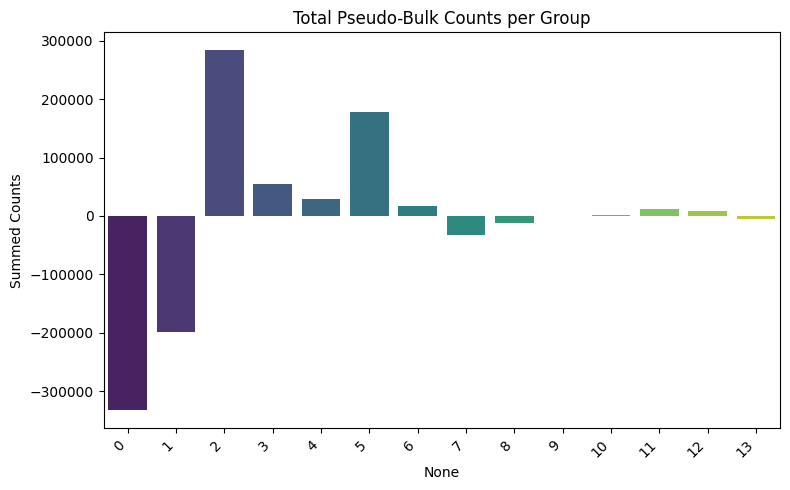

/home/jovyan/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


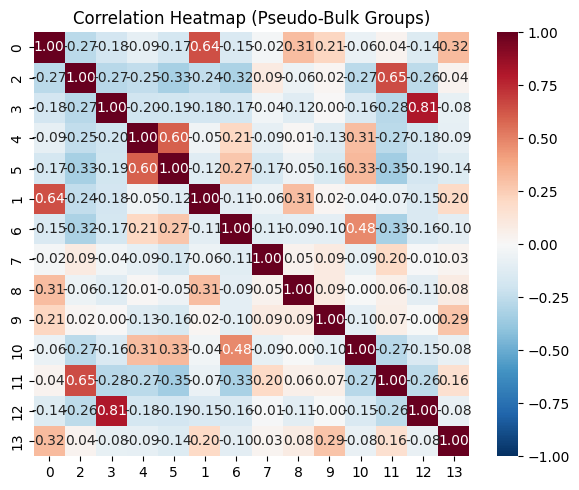

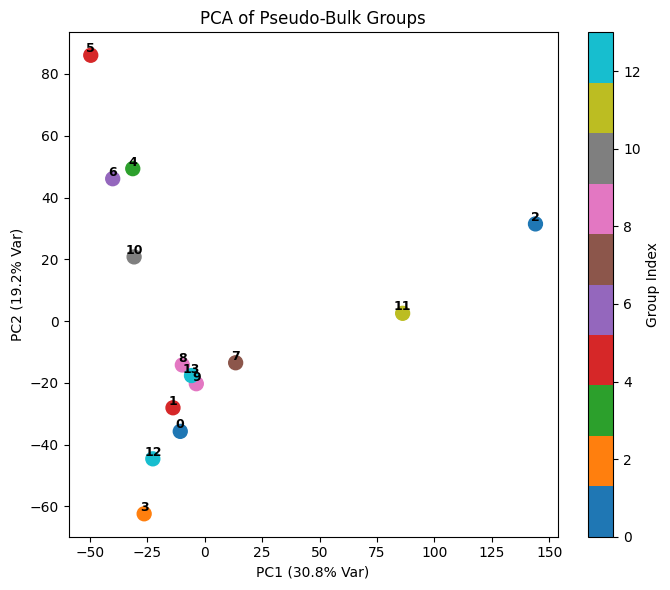

Pseudo-bulk matrix shape: (2000, 14)

Performing diffusion pseudotime analysis...
Diffusion pseudotime added to adata.obs['dpt_pseudotime'].


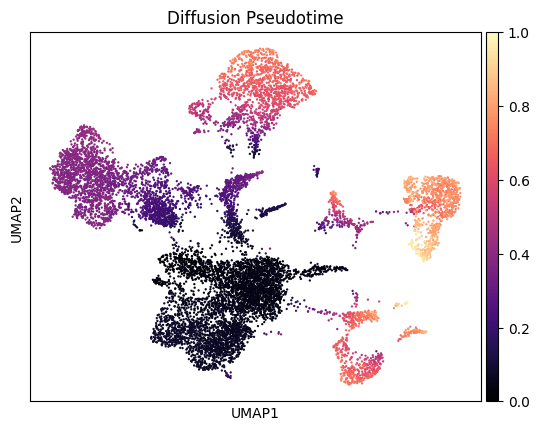


All done!


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Full Single-Cell RNA-seq Pipeline (Scanpy-based) + Pseudo-Bulk + Pseudotime
--------------------------------------------------------------------------

This script demonstrates:
1) Downloading/merging 10x-like scRNA-seq datasets from GEO.
2) Basic QC filtering, normalization, and clustering (Leiden + UMAP).
3) Marker gene detection and cluster annotation with a static marker dictionary.
4) Pseudo-bulk generation and plotting (barplot, correlation heatmap, PCA).
5) Diffusion pseudotime as a simple trajectory inference method.

Adjust function parameters (thresholds, group keys, etc.) to your needs.
"""

import os
import gzip
import pandas as pd
import numpy as np
import anndata as an
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from urllib.request import urlretrieve
from pathlib import Path
from typing import List, Dict
import scipy.sparse as sp

# --------------------------------------------------------------------------------
# Part 1: Data Ingestion and Merging
# --------------------------------------------------------------------------------

def fetch_and_merge_10x_datasets(sample_records: List[Dict[str, str]], dest_folder: str = "data") -> an.AnnData:
    """
    Fetches scRNA-seq data from 10X Genomics-like files (hosted on GEO),
    merges them into a single AnnData object, and applies basic labeling.
    """
    os.makedirs(dest_folder, exist_ok=True)
    
    adata_list = []
    label_list = []
    
    for sample_info in sample_records:
        # Extract sample metadata
        accession_id = sample_info['accession']
        filename_prefix = sample_info['file_prefix']
        label = sample_info['label']
        
        # Define file paths
        data_files = {
            'matrix': f"{filename_prefix}_matrix.mtx",
            'barcodes': f"{filename_prefix}_barcodes.tsv",
            'features': f"{filename_prefix}_features.tsv"
        }
        local_paths = {k: Path(dest_folder) / v for k, v in data_files.items()}
        
        # Download and decompress each file if needed
        for file_type, target_file in local_paths.items():
            gz_file = target_file.with_suffix(target_file.suffix + '.gz')
            
            if target_file.exists():
                print(f"File {target_file} already exists, skipping download...")
                continue
                
            # Download if gz file not found
            if not gz_file.exists():
                ext = 'mtx' if file_type == 'matrix' else 'tsv'
                url = f"https://www.ncbi.nlm.nih.gov/geo/download/?acc={accession_id}&format=file&file={filename_prefix}_{file_type}.{ext}.gz"
                # Escape underscores and periods
                url = url.replace('_', '%5F').replace('.', '%2E')
                print(f"Downloading {file_type} for {accession_id}...")
                urlretrieve(url, gz_file)
            
            # Decompress file
            print(f"Decompressing {gz_file}...")
            with gzip.open(gz_file, 'rb') as f_in, open(target_file, 'wb') as f_out:
                f_out.write(f_in.read())
        
        # Build AnnData
        adata_sample = sc.read_mtx(local_paths['matrix']).T
        
        # Add cell barcodes and sample labels
        barcodes = pd.read_csv(local_paths['barcodes'], header=None)[0]
        adata_sample.obs_names = [f"{label}_{x}" for x in barcodes]
        
        # Add gene annotation
        feature_table = pd.read_csv(local_paths['features'], sep='\t', header=None)
        adata_sample.var_names = feature_table[0]  # Typically Ensembl IDs
        adata_sample.var['gene_symbols'] = feature_table[1].values
        
        # If there is a third column, treat it as a feature type
        if feature_table.shape[1] > 2:
            adata_sample.var['feature_type'] = feature_table[2].values
            
        # Add columns from the sample_info dictionary as observation metadata
        for key, val in sample_info.items():
            if key not in ['accession', 'file_prefix']:
                adata_sample.obs[key] = val
        
        adata_list.append(adata_sample)
        label_list.append(label)
    
    # Concatenate all AnnData objects
    adata_merged = an.concat(adata_list, axis=0, join='outer', label='batch', keys=label_list)
    adata_merged.obs_names_make_unique()
    
    # Replace Ensembl IDs with gene symbols
    first_feat_file = Path(dest_folder) / f"{sample_records[0]['file_prefix']}_features.tsv"
    feats_df = pd.read_csv(first_feat_file, sep='\t', header=None)
    ens_to_symbol = dict(zip(feats_df[0], feats_df[1]))
    adata_merged.var_names = [ens_to_symbol.get(g, g) for g in adata_merged.var_names]
    adata_merged.var_names_make_unique()
    
    # Check for mitochondrial genes
    adata_merged.var['mt'] = adata_merged.var_names.str.startswith('MT-')
    print(f"Merged AnnData contains {adata_merged.n_obs} cells and {adata_merged.n_vars} genes.")
    
    return adata_merged

# --------------------------------------------------------------------------------
# Part 2: Cluster Annotation
# --------------------------------------------------------------------------------

def assign_cell_identity_with_markers(adata, top_n=50):
    """
    Annotates cluster identities using a custom dictionary of cell-type markers.
    This approach uses rank_genes_groups output and attempts to match top genes.
    """
    print("Initiating cluster annotation with marker database...")
    
    # Master marker dictionary
    marker_db = {
        # Immune
        'T cells': ['CD3D', 'CD3E', 'CD3G', 'CD2', 'CD7', 'IL7R', 'LCK', 'CD28'],
        'CD4+ T cells': ['CD4', 'IL7R', 'CCR7', 'LEF1', 'TCF7', 'MAL'],
        'CD8+ T cells': ['CD8A', 'CD8B', 'GZMK', 'GZMA', 'CCL5', 'GNLY'],
        'Regulatory T cells': ['FOXP3', 'IL2RA', 'CTLA4', 'TIGIT', 'IKZF2'],
        'B cells': ['CD19', 'MS4A1', 'CD79A', 'CD79B', 'HLA-DRA', 'CD74'],
        'Plasma cells': ['JCHAIN', 'MZB1', 'SSR4', 'XBP1', 'IGHA1', 'IGHG1'],
        'NK cells': ['NCAM1', 'NKG7', 'GNLY', 'KLRD1', 'KLRF1', 'FCGR3A'],
        'Monocytes': ['CD14', 'LYZ', 'VCAN', 'S100A9', 'S100A8', 'FCN1'],
        'Macrophages': ['CD68', 'MSR1', 'MARCO', 'VSIG4', 'C1QA', 'C1QB', 'APOE'],
        'Dendritic cells': ['CLEC9A', 'CLEC10A', 'CD1C', 'FCER1A', 'ITGAX', 'IRF8'],
        'Neutrophils': ['ELANE', 'MPO', 'S100A8', 'S100A9', 'CEACAM8', 'FCGR3B'],
        'Mast cells': ['CPA3', 'TPSAB1', 'TPSB2', 'MS4A2', 'HDC', 'KIT'],
        
        # Endothelial
        'Endothelial cells': ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'SELE', 'KDR', 'TEK'],
        'Lymphatic endothelial': ['PROX1', 'PDPN', 'FLT4', 'CCL21', 'LYVE1'],
        'Pericytes': ['RGS5', 'PDGFRB', 'DES', 'ACTA2', 'MYH11', 'MCAM', 'CSPG4'],
        
        # Epithelial
        'Epithelial cells': ['EPCAM', 'KRT8', 'KRT18', 'KRT19', 'CDH1', 'CLDN4', 'CLDN7'],
        
        # Stromal/Mesenchymal
        'Fibroblasts': ['DCN', 'LUM', 'COL1A1', 'COL1A2', 'COL3A1', 'COL6A1', 'PDGFRA', 'FAP'],
        'Smooth muscle': ['ACTA2', 'TAGLN', 'MYH11', 'CNN1', 'DES', 'TPM2', 'MYL9'],
        'Skeletal muscle': ['MYH1', 'MYH2', 'ACTA1', 'TTN', 'MYBPC1', 'CKM', 'MB'],
        'Adipocytes': ['ADIPOQ', 'LEP', 'FABP4', 'PLIN1', 'CFD', 'PPARG'],
        
        # Other specialized cell types
        'Neurons': ['MAP2', 'RBFOX3', 'TUBB3', 'SYP', 'SNAP25', 'NEFL', 'NEFM'],
        'Oligodendrocytes': ['MBP', 'MOG', 'MAG', 'PLP1', 'OLIG1', 'OLIG2'],
        'Astrocytes': ['GFAP', 'AQP4', 'SLC1A3', 'SLC1A2', 'ALDH1L1'],
        'Microglia': ['CX3CR1', 'P2RY12', 'ITGAM', 'TMEM119', 'TREM2', 'APOE'],
        'Hepatocytes': ['ALB', 'APOB', 'HP', 'FGA', 'FGB', 'APOA1', 'TTR'],
        'Erythrocytes': ['HBA1', 'HBA2', 'HBB', 'ALAS2', 'GYPA', 'SLC4A1'],
        'Interferon-responsive': ['ISG15', 'IFI6', 'IFI27', 'IFIT1', 'IFIT3', 'MX1', 'OAS1'],
    }
    
    # Reverse lookup: gene -> [cell type(s)]
    marker_to_ct = {}
    for ct, genes in marker_db.items():
        for g in genes:
            marker_to_ct.setdefault(g, []).append(ct)
    
    # Identify clusters
    clusters = adata.uns['rank_genes_groups']['names'].dtype.names
    cluster_id_to_annotation = {}
    
    for cluster in clusters:
        # Gather top significant markers
        candidate_markers = []
        for i in range(min(top_n, len(adata.uns['rank_genes_groups']['names'][cluster]))):
            m_name = adata.uns['rank_genes_groups']['names'][cluster][i]
            score = adata.uns['rank_genes_groups']['scores'][cluster][i]
            pval = adata.uns['rank_genes_groups']['pvals'][cluster][i]
            if pval < 0.05:  # only consider significant
                candidate_markers.append((m_name, score, i))
        
        # Tally which cell types these markers suggest
        matching_celltypes = {}
        for m_name, score, rank in candidate_markers:
            if m_name in marker_to_ct:
                for ct in marker_to_ct[m_name]:
                    matching_celltypes.setdefault(ct, []).append((m_name, score, rank))
        
        # Compute an overall "score" for each cell type
        ct_scoring = {}
        for ct, marker_info in matching_celltypes.items():
            combined_score = sum([x[1] * (1 - x[2]/top_n) for x in marker_info])
            proportion_covered = len(marker_info) / len(marker_db[ct])
            final_val = combined_score * (1 + proportion_covered)
            ct_scoring[ct] = (final_val, [x[0] for x in marker_info])
        
        if ct_scoring:
            # Sort by combined score
            sorted_ct = sorted(ct_scoring.items(), key=lambda x: x[1][0], reverse=True)
            # Take top 2 for an annotation
            top2 = sorted_ct[:2]
            annotation_text = " / ".join([f"{ct} ({', '.join(marker_names[:3])})"
                                          for ct, (_, marker_names) in top2])
            cluster_id_to_annotation[cluster] = annotation_text
        else:
            # If no matches found, fallback
            limited_markers = [x[0] for x in candidate_markers[:3]] if candidate_markers else ["NoSigMarkers"]
            cluster_id_to_annotation[cluster] = f"Unknown (Top: {', '.join(limited_markers)})"
    
    # Attach to adata
    adata.obs['custom_cell_type'] = adata.obs['clusters'].map(cluster_id_to_annotation)
    print("Annotation complete.")
    return cluster_id_to_annotation

# --------------------------------------------------------------------------------
# Part 3: Visualization of Top Markers
# --------------------------------------------------------------------------------

def display_leading_markers(adata, n_genes=10):
    """
    Quickly visualize the top markers across clusters with a dotplot and heatmap.
    """
    marker_dict = {}
    
    for cluster_name in adata.obs['clusters'].unique():
        marker_info = pd.DataFrame({
            'names': adata.uns['rank_genes_groups']['names'][cluster_name][:n_genes],
            'scores': adata.uns['rank_genes_groups']['scores'][cluster_name][:n_genes],
            'pvals': adata.uns['rank_genes_groups']['pvals'][cluster_name][:n_genes],
            'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj'][cluster_name][:n_genes]
        })
        marker_dict[cluster_name] = marker_info
    
    # Collect them all
    combined_genes = []
    for cl, df_ in marker_dict.items():
        combined_genes.extend(df_['names'].tolist())
    # De-dup while preserving order
    final_genes = []
    seen_set = set()
    for gene in combined_genes:
        if gene not in seen_set:
            final_genes.append(gene)
            seen_set.add(gene)
    
    # Limit
    if len(final_genes) > 50:
        final_genes = final_genes[:50]
        
    # Dotplot
    sc.pl.dotplot(adata, final_genes, groupby='clusters', dendrogram=True)
    
    # Heatmap
    sc.pl.heatmap(
        adata, final_genes, groupby='clusters', 
        swap_axes=True, show_gene_labels=True, 
        vmin=-2, vmax=2, cmap='viridis'
    )
    return marker_dict

# --------------------------------------------------------------------------------
# Part 4: DE Analysis Between Conditions Within Each Cluster
# --------------------------------------------------------------------------------

def compare_clusters_by_condition(adata, cluster_key='clusters', condition_key='condition', p_cut=0.05, min_cell_threshold=3):
    """
    Compares gene expression between two conditions within each cluster.
    Logs results and returns a dictionary of DE results (similar to pseudo-bulk concept
    but still single-cell-based).
    """
    
    print(f"Starting condition-based comparison within each cluster: {condition_key}.")
    unique_conditions = adata.obs[condition_key].unique()
    
    if len(unique_conditions) != 2:
        raise ValueError(f"Expected 2 conditions, found {len(unique_conditions)}.")
        
    cond_a, cond_b = unique_conditions
    print(f"Comparing '{cond_b}' against '{cond_a}' for each cluster.")
    
    results_summary = {}
    
    for cluster_label in adata.obs[cluster_key].unique():
        print(f"\nEvaluating cluster {cluster_label}...")
        subset_data = adata[adata.obs[cluster_key] == cluster_label].copy()
        
        # Count cells in each condition
        cond_counts = subset_data.obs[condition_key].value_counts()
        count_a = cond_counts.get(cond_a, 0)
        count_b = cond_counts.get(cond_b, 0)
        
        print(f"  Condition counts: {count_a} in {cond_a}, {count_b} in {cond_b}.")
        
        if count_a < min_cell_threshold or count_b < min_cell_threshold:
            print(f"  Insufficient cells (min: {min_cell_threshold}) -> skipping.")
            continue
        
        try:
            sc.tl.rank_genes_groups(
                subset_data, groupby=condition_key, groups=[cond_b], 
                reference=cond_a, method='wilcoxon', corr_method='bonferroni',
                use_raw=True
            )
            cluster_de = sc.get.rank_genes_groups_df(subset_data, group=cond_b)
            sig_genes = cluster_de[cluster_de['pvals_adj'] < p_cut]
            
            if not sig_genes.empty:
                sig_genes = sig_genes.dropna(subset=['logfoldchanges'])
                if not sig_genes.empty:
                    sig_genes['direction'] = sig_genes['logfoldchanges'].apply(
                        lambda x: 'up' if x > 0 else 'down'
                    )
                    sig_genes['abs_logfc'] = np.abs(sig_genes['logfoldchanges'])
                    up_count = np.sum(sig_genes['direction'] == 'up')
                    down_count = np.sum(sig_genes['direction'] == 'down')
                    
                    print(f"  Identified {len(sig_genes)} genes with adj p < {p_cut}.")
                    print(f"    {up_count} up in {cond_b}, {down_count} down in {cond_b}.")
                    
                    results_summary[cluster_label] = sig_genes.sort_values('abs_logfc', ascending=False)
                else:
                    print(f"  No valid foldchanges in cluster {cluster_label}.")
                    results_summary[cluster_label] = None
            else:
                print(f"  No significant DE genes in cluster {cluster_label}.")
                results_summary[cluster_label] = None
        
        except ValueError as exc:
            print(f"  Error in analysis: {exc}")
            results_summary[cluster_label] = None
    
    return results_summary

# --------------------------------------------------------------------------------
# Part 5: Pseudo-Bulk Creation
# --------------------------------------------------------------------------------

def create_pseudobulk_counts(adata: an.AnnData, groupby: str = "clusters", layer: str = None) -> pd.DataFrame:
    """
    Aggregates scRNA-seq counts into pseudo-bulk counts by summing all cells
    within each group (e.g., cluster or cluster+condition).
    
    Parameters:
    -----------
    adata : an.AnnData
        Annotated data matrix with .X or a specified layer holding counts.
    groupby : str
        The column in adata.obs that defines how cells are grouped.
    layer : str, optional
        If raw counts are stored in a layer (e.g., 'counts'), specify here;
        by default, .X is used.

    Returns:
    --------
    pseudo_bulk_df : pandas.DataFrame
        DataFrame of shape (n_genes, n_groups) containing summed counts
        for each group in columns and genes in rows.
    """
    if layer is not None:
        matrix = adata.layers[layer]
    else:
        matrix = adata.X
    
    # Convert to dense if needed
    if not isinstance(matrix, np.ndarray):
        matrix = matrix.toarray()
    
    groups = adata.obs[groupby]
    unique_groups = groups.unique()
    gene_names = adata.var_names
    
    pseudo_bulk = np.zeros((matrix.shape[1], len(unique_groups)))
    pseudo_bulk_df = pd.DataFrame(pseudo_bulk, index=gene_names, columns=unique_groups)
    
    for grp in unique_groups:
        mask = (groups == grp)
        pseudo_bulk_df[grp] = matrix[mask].sum(axis=0)
    
    return pseudo_bulk_df

# --------------------------------------------------------------------------------
# Part 6: Pseudo-Bulk Visualization
# --------------------------------------------------------------------------------

def plot_pseudobulk_counts(pseudo_bulk_df: pd.DataFrame):
    """
    Generates a few standard plots for pseudo-bulk data:
     1) Bar plot of total counts per group.
     2) Correlation heatmap among groups.
     3) PCA scatter plot of groups (each group is one sample).
    """
    
    # 1) Bar plot of total counts
    total_counts = pseudo_bulk_df.sum(axis=0)  # sum across genes for each group
    plt.figure(figsize=(8,5))
    sns.barplot(x=total_counts.index, y=total_counts.values, palette='viridis')
    plt.title("Total Pseudo-Bulk Counts per Group")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Summed Counts")
    plt.tight_layout()
    plt.show()
    
    # 2) Correlation heatmap
    log_df = np.log1p(pseudo_bulk_df)  # log1p to handle zeros
    if log_df.isna().any().any():
        print("Warning: NaNs detected in pseudo-bulk data. Filling them with 0.")
        log_df = log_df.fillna(0)
    
    corr_matrix = log_df.corr(method='pearson')
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap (Pseudo-Bulk Groups)")
    plt.tight_layout()
    plt.show()
    
    # 3) PCA
    X = log_df.T.values  # shape: (n_groups, n_genes)
    group_labels = log_df.columns
    
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)
    
    pc1_explained = pca.explained_variance_ratio_[0] * 100
    pc2_explained = pca.explained_variance_ratio_[1] * 100
    
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(pcs[:,0], pcs[:,1], 
                          c=range(len(group_labels)), cmap='tab10', s=100)
    for i, label in enumerate(group_labels):
        plt.text(pcs[i,0], pcs[i,1], label, fontsize=9,
                 ha='center', va='bottom', weight='bold')
    plt.colorbar(scatter, label='Group Index')
    plt.xlabel(f"PC1 ({pc1_explained:.1f}% Var)")
    plt.ylabel(f"PC2 ({pc2_explained:.1f}% Var)")
    plt.title("PCA of Pseudo-Bulk Groups")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------
# Part 7: Simple Diffusion Pseudotime
# --------------------------------------------------------------------------------

def run_diffusion_pseudotime(adata: an.AnnData, root_cell: str = None):
    """
    Runs diffusion pseudotime (DPT) on the given AnnData object.
    Requires that sc.pp.neighbors(...) has already been called.
    Optionally specify a root cell (by .obs_names string).
    """
    if root_cell and root_cell in adata.obs_names:
        adata.uns['iroot'] = np.where(adata.obs_names == root_cell)[0][0]
    else:
        # If no root specified, pick the first cell
        adata.uns['iroot'] = 0
    
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata, n_dcs=10)
    print("Diffusion pseudotime added to adata.obs['dpt_pseudotime'].")
    
    # Visualize
    sc.pl.umap(adata, color='dpt_pseudotime', cmap='magma', title='Diffusion Pseudotime')

# --------------------------------------------------------------------------------
# Main Execution
# --------------------------------------------------------------------------------

if __name__ == "__main__":
    # Example sample data (change these to your actual samples/accessions)
    sample_data = [
        {'accession': 'GSM6611295', 'file_prefix': 'GSM6611295_P15306_5001', 'condition': 'pre', 'subject': '1', 'label': 'subject1_pre'},
        {'accession': 'GSM6611296', 'file_prefix': 'GSM6611296_P15306_5002', 'condition': 'post', 'subject': '1', 'label': 'subject1_post'},
        {'accession': 'GSM6611297', 'file_prefix': 'GSM6611297_P14601_4004', 'condition': 'pre', 'subject': '2', 'label': 'subject2_pre'},
        {'accession': 'GSM6611298', 'file_prefix': 'GSM6611298_P14601_4005', 'condition': 'post', 'subject': '2', 'label': 'subject2_post'},
        {'accession': 'GSM6611299', 'file_prefix': 'GSM6611299_P15306_5003', 'condition': 'pre', 'subject': '3', 'label': 'subject3_pre'},
        {'accession': 'GSM6611300', 'file_prefix': 'GSM6611300_P15306_5004', 'condition': 'post', 'subject': '3','label': 'subject3_post'}
    ]
    
    print("Fetching and merging data...")
    adata_full = fetch_and_merge_10x_datasets(sample_data)

    # Basic stats
    print(f"Number of Genes: {adata_full.n_vars}")
    print(f"Number of Cells: {adata_full.n_obs}")

    # Check for NaNs
    if sp.issparse(adata_full.X):
        print("Sparse data: checking non-zero elements for NaN.")
        if np.isnan(adata_full.X.data).any():
            print(f"NaN count in sparse data: {np.sum(np.isnan(adata_full.X.data))}")
        else:
            print("No NaN values among non-zero elements.")
    else:
        nan_rows = np.isnan(adata_full.X).any(axis=1)
        nan_cols = np.isnan(adata_full.X).any(axis=0)
        print(f"Rows with NaN: {np.sum(nan_rows)}")
        print(f"Columns with NaN: {np.sum(nan_cols)}")
    
    # Compute QC metrics
    sc.pp.calculate_qc_metrics(adata_full, qc_vars=[], percent_top=None, log1p=False, inplace=True)
    
    # Handle mitochondrial genes
    mt_mask = adata_full.var_names.str.startswith(('MT-', 'mt-'))
    mt_count = np.sum(mt_mask)
    print(f"Detected {mt_count} mitochondrial gene(s).")
    if mt_count > 0:
        adata_full.var['mt'] = mt_mask
        sc.pp.calculate_qc_metrics(adata_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    else:
        print("No 'MT-' or 'mt-' prefixes found for mitochondrial genes.")
        adata_full.obs['pct_counts_mt'] = 0

    # Basic QC plots
    print("Drawing QC histograms...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sns.histplot(adata_full.obs['n_genes_by_counts'], bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Gene Counts per Cell")
    axes[0, 0].axvline(200, color='red', linestyle='--', label='Threshold=200')
    axes[0, 0].legend()

    sns.histplot(adata_full.obs['total_counts'], bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title("UMI Counts per Cell")
    axes[0, 1].set_xscale('log')

    sns.histplot(adata_full.obs['pct_counts_mt'], bins=50, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title("Mito % per Cell")
    axes[1, 0].axvline(20, color='red', linestyle='--', label='20% threshold')
    axes[1, 0].legend()

    scatt = axes[1, 1].scatter(
        adata_full.obs['total_counts'], 
        adata_full.obs['n_genes_by_counts'], 
        c=adata_full.obs['pct_counts_mt'], cmap='viridis', s=10, alpha=0.7
    )
    axes[1, 1].set_xscale('log')
    cb = plt.colorbar(scatt, ax=axes[1, 1])
    cb.set_label('Mito %')
    axes[1, 1].set_title("Genes vs UMI (Colored by Mito %)")
    plt.tight_layout()
    plt.show()

    # QC by batch
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sc.pl.violin(adata_full, 'total_counts', groupby='batch', ax=axes[0], show=False)
    axes[0].set_title("UMI by Sample")
    axes[0].set_yscale('log')

    sc.pl.violin(adata_full, 'n_genes_by_counts', groupby='batch', ax=axes[1], show=False)
    axes[1].set_title("Gene Count by Sample")

    sc.pl.violin(adata_full, 'pct_counts_mt', groupby='batch', ax=axes[2], show=False)
    axes[2].set_title("Mito % by Sample")
    plt.tight_layout()
    plt.show()

    # Filtering thresholds
    min_genes = 300
    min_cells = 20
    max_mito = 15
    min_counts = 1000
    max_counts = 15000

    print(f"Initial dataset: {adata_full.n_obs} cells, {adata_full.n_vars} genes.")
    adata_filtered = adata_full[
        (adata_full.obs['n_genes_by_counts'] >= min_genes) &
        (adata_full.obs['pct_counts_mt'] <= max_mito)
    ]

    if min_counts:
        adata_filtered = adata_filtered[adata_filtered.obs['total_counts'] >= min_counts]
    if max_counts:
        adata_filtered = adata_filtered[adata_filtered.obs['total_counts'] <= max_counts]

    sc.pp.filter_genes(adata_filtered, min_cells=min_cells)
    print(f"After QC filter: {adata_filtered.n_obs} cells, {adata_filtered.n_vars} genes.")

    # -------------------------------------------------------
    # Normalization + raw storage + log transform
    # -------------------------------------------------------
    sc.pp.normalize_total(adata_filtered, target_sum=1e4)

    # Store the unlogged expression in `adata_filtered.raw`
    adata_filtered.raw = adata_filtered.copy()  # <--- NEW step

    # Now log-transform the main AnnData
    sc.pp.log1p(adata_filtered)

    # Highly variable genes + scaling
    sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000, subset=True)
    sc.pp.scale(adata_filtered, zero_center=True)

    # PCA, neighbors, clustering
    sc.tl.pca(adata_filtered, svd_solver='arpack')
    sc.pp.neighbors(adata_filtered, n_neighbors=20, n_pcs=30)
    sc.tl.leiden(adata_filtered, resolution=0.3, n_iterations=3, flavor='igraph', directed=False, key_added='clusters')
    sc.tl.umap(adata_filtered)

    sc.pl.umap(
        adata_filtered, color='clusters', add_outline=True, 
        legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=True
    )

    # Evaluate clustering
    cluster_labels = adata_filtered.obs['clusters']
    sil_score_val = silhouette_score(adata_filtered.obsm['X_pca'], cluster_labels)
    print(f"Silhouette Score: {sil_score_val}")

    # Rank genes
    sc.tl.rank_genes_groups(adata_filtered, groupby='clusters', method='wilcoxon', corr_method='bonferroni', use_raw=True)
    cluster_marker_df = sc.get.rank_genes_groups_df(adata_filtered, group=None)
    cluster_marker_df = pd.DataFrame(cluster_marker_df)

    # Summarize top 3 markers per cluster
    highlight_dict = {}
    cluster_set = adata_filtered.uns['rank_genes_groups']['names'].dtype.names
    for cl in cluster_set:
        subdf = cluster_marker_df[cluster_marker_df['group'] == cl].head(3)
        highlight_dict[cl] = subdf
    top_genes_aggregate = pd.concat(highlight_dict.values(), keys=highlight_dict.keys())
    print("Top 3 markers per cluster:\n", top_genes_aggregate)

    # Cell type annotation
    cluster_assignments = assign_cell_identity_with_markers(adata_filtered, top_n=50)

    print("\nCluster Annotations:")
    for cl_id, desc in cluster_assignments.items():
        print(f"  Cluster {cl_id}: {desc}")

    sc.pl.umap(adata_filtered, color='custom_cell_type', legend_loc='on data', legend_fontsize=8, title='Cell Types')
    sc.pl.umap(adata_filtered, color='clusters', legend_loc='on data', legend_fontsize=10, title='Numeric Clusters')

    # Cluster distribution
    cluster_count_vals = adata_filtered.obs['clusters'].value_counts()
    total_count = len(adata_filtered.obs)
    percentages = (cluster_count_vals / total_count) * 100
    print("\nCluster composition (%):\n", percentages)

    # Additional marker visualization
    top_markers_dict = display_leading_markers(adata_filtered, n_genes=10)

    # Compare conditions within each cluster
    print("\nIntra-cluster DE between 'condition' states:")
    de_comparison_results = compare_clusters_by_condition(adata_filtered, min_cell_threshold=5)
    os.makedirs('de_results', exist_ok=True)
    for clust, df_out in de_comparison_results.items():
        if df_out is not None and not df_out.empty:
            output_file = f'de_results/cluster_{clust}_diffexp.csv'
            df_out.to_csv(output_file, index=False)
            print(f"Saved DE results to: {output_file}")
            top5 = df_out[['names', 'logfoldchanges', 'pvals_adj', 'direction']].head(5)
            print(f"\nTop 5 DE genes for cluster {clust}:\n", top5)

    # ----------------------------------------------------------------------------
    # Pseudo-Bulk Analysis
    # ----------------------------------------------------------------------------

    print("\nGenerating pseudo-bulk counts (grouped by clusters)...")
    pseudo_bulk_df = create_pseudobulk_counts(adata_filtered, groupby='clusters')
    print("Pseudo-bulk DataFrame shape:", pseudo_bulk_df.shape)

    # Quick plot of pseudo-bulk data
    plot_pseudobulk_counts(pseudo_bulk_df)

    # Next steps:
    #   • Save pseudo_bulk_df to a CSV and analyze with bulk RNA-seq tools
    #   • Or keep it in Python for simplified comparisons
    pseudo_bulk_df.to_csv("pseudobulk_by_cluster.csv")
    print("Pseudo-bulk matrix shape:", pseudo_bulk_df.shape)

    # ----------------------------------------------------------------------------
    # Simple Diffusion Pseudotime
    # ----------------------------------------------------------------------------

    print("\nPerforming diffusion pseudotime analysis...")
    # We already have neighbors computed on adata_filtered
    # Optionally specify a cell name as root if you know one
    run_diffusion_pseudotime(adata_filtered, root_cell=None)

    print("\nAll done!")